![title](./RET_iso.png)

In [1]:
# Copyright (c) 2018 The Harmonica Developers.
# Distributed under the terms of the BSD 3-Clause License.
# SPDX-License-Identifier: BSD-3-Clause
#
# This code is part of the Fatiando a Terra project (https://www.fatiando.org)
#
"""
Function to calculate the thickness of the roots and antiroots assuming the
Airy isostatic hypothesis.
"""
import numpy as np
import xarray as xr


def isostasy_airy(
    basement_elevation,
    layer_thickness=(),
    layer_density=(),    
    density_crust=2.8e3,
    density_mantle=3.3e3,
    reference_depth=30e3,
):
    r"""
    Calculate the isostatic Moho depth from rock equvalent topography using Airy's hypothesis.
    According to the Airy hypothesis of isostasy, topography above sea level is
    supported by a thickening of the crust (a root) while oceanic basins are
    supported by a thinning of the crust (an anti-root). This assumption is
    usually
    .. figure:: ../../_static/figures/airy-isostasy.svg
        :align: center
        :width: 400px
        *Schematic of isostatic compensation following the Airy hypothesis.*
    The relationship between the topographic/bathymetric heights (:math:`h`)
    and the root thickness (:math:`r`) is governed by mass balance relations
    and can be found in classic textbooks like [TurcotteSchubert2014]_ and
    [Hofmann-WellenhofMoritz2006]_.
    On the continents (positive topographic heights):
    .. math ::
        r = \frac{\rho_{c}}{\rho_m - \rho_{c}} h
    while on the oceans (negative topographic heights):
    .. math ::
        r = \frac{\rho_{c} - \rho_w}{\rho_m - \rho_{c}} h
    in which :math:`h` is the topography/bathymetry, :math:`\rho_m` is the
    density of the mantle, :math:`\rho_w` is the density of the water, and
    :math:`\rho_{c}` is the density of the crust.
    The computed root thicknesses will be added to the given reference Moho
    depth (:math:`H`) to arrive at the isostatic Moho depth. Use
    ``reference_depth=0`` if you want the values of the root thicknesses
    instead.
    Parameters
    ----------
    basement_elevation : array or :class:`xarray.DataArray`
        Basement elevation in meters. It usually refer to topography height and bathymetry depth without sediment cover. 
        When considering sedimentary layer, it refer to crystalline basement. It is usually prudent
        to use floating point values instead of integers to avoid integer
        division errors.
    layer_thickness : tuple
    layer_density : tuple array or :class:`xarray.DataArray`
    density_crust : float
        Density of the crust in :math:`kg/m^3`.
    density_mantle : float
        Mantle density in :math:`kg/m^3`.
    density_water : float
        Water density in :math:`kg/m^3`.
    reference_depth : float
        The reference Moho depth (:math:`H`) in meters.
    Returns
    -------
    moho_depth : array or :class:`xarray.DataArray`
         The isostatic Moho depth in meters.
    """

    # Define scale factor to calculate Airy root
    scale = density_crust / (density_mantle-density_crust)
    
    # For the case: multi-layers above topography/basement
    if type(layer_thickness) is tuple:
        # Define total mass of layers abrove topography/basement
        layer_mass = tuple(ele1 * ele2 for ele1, ele2 in zip(layer_thickness, layer_density))
        # Calculate equvalent topography
        rock_equavalent_topography=basement_elevation+sum(list(layer_mass))/density_crust
    else:
        # For the case: a single layer above topography/basement
        layer_mass = layer_thickness*layer_density
        rock_equavalent_topography=basement_elevation+layer_mass/density_crust
    # Calculate Moho depth
    moho = rock_equavalent_topography * scale + reference_depth
    if isinstance(moho, xr.DataArray):
        moho.name = "moho_depth"
        moho.attrs["isostasy"] = "Airy"
        moho.attrs["density_crust"] = str(density_crust)
        moho.attrs["density_mantle"] = str(density_mantle)
    return moho

<xarray.DataArray 'moho_depth' (latitude: 171, longitude: 161)>
array([[16119.38, 16635.52, 16832.52, ...,  9736.58,  9645.96,  9409.56],
       [16347.9 , 16808.88, 17399.88, ...,  9338.64,  9334.7 ,  9267.72],
       [16056.34, 16584.3 , 17317.14, ...,  9153.46,  9311.06,  9295.3 ],
       ...,
       [13471.7 , 11950.86, 11521.4 , ..., 30229.6 , 30207.2 , 30218.4 ],
       [13475.64, 12431.54, 11773.56, ..., 30184.8 , 30162.4 , 30162.4 ],
       [13459.88, 12884.64, 12080.88, ..., 30207.2 , 30184.8 , 30162.4 ]])
Coordinates:
  * longitude  (longitude) float64 -20.0 -19.5 -19.0 -18.5 ... 59.0 59.5 60.0
  * latitude   (latitude) float64 -40.0 -39.5 -39.0 -38.5 ... 44.0 44.5 45.0
Attributes:
    isostasy:        Airy
    density_crust:   2800.0
    density_mantle:  3300.0


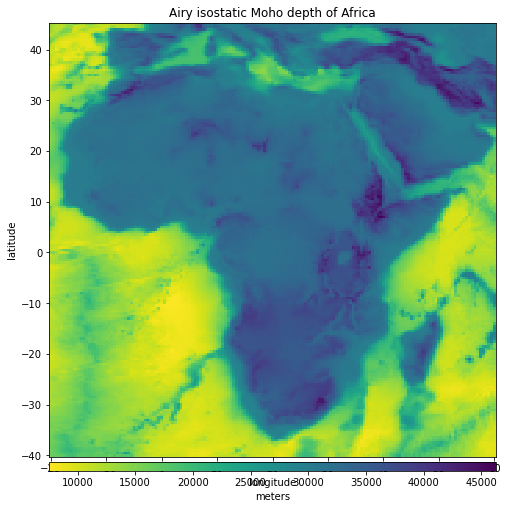

In [2]:
import matplotlib.pyplot as plt

import harmonica as hm

# Load the elevation model and cut out the portion of the data corresponding to
# Africa
data = hm.datasets.fetch_topography_earth()
region = (-20, 60, -40, 45)
data_africa = data.sel(latitude=slice(*region[2:]), longitude=slice(*region[:2]))
#print("Topography/bathymetry grid:")
#print(data_africa)

oceans = np.array(data_africa.topography < 0)
water_thickness = data_africa.topography*oceans*-1

sedi_thickness=water_thickness*0.5
# Calculate the isostatic Moho depth using the default values for densities and
# reference Moho

layer_thickness=(water_thickness,sedi_thickness)
layer_density=(1030,2400)


moho = isostasy_airy(data_africa.topography-sedi_thickness,layer_thickness=layer_thickness,layer_density=layer_density)
#print("\nMoho depth grid:")
print(moho)
# Draw the maps

plt.figure(figsize=(8, 9.5))
ax = plt.axes()
pc = moho.plot.pcolormesh(
    ax=ax, cmap="viridis_r", add_colorbar=False
)
plt.colorbar(pc, ax=ax, orientation="horizontal", pad=0.01, aspect=50, label="meters")
ax.set_title("Airy isostatic Moho depth of Africa")
plt.show()
